# Intro

The W4 project is a Kaggle competetion titled "Natural Language Processing with Disaster Tweets", and this is a dataset of 10000 hand labeled tweets. We are tasked with creating an NLP model that can determine if these tweets are related to a real disaster or not. The Kaggle score will be determined using F1 score on the model. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # or "tensorflow" or "torch"
import numpy as np
import pandas as pd 
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import *
from keras.layers import *
from keras.callbacks import *

To start, we need to read in our packages and read in the data. This is the data downloaded from the Kaggle competition.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
test.shape

(3263, 4)

In [5]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [6]:
test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [7]:
train.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [8]:
test.count()

id          3263
keyword     3237
location    2158
text        3263
dtype: int64

<Axes: xlabel='target', ylabel='count'>

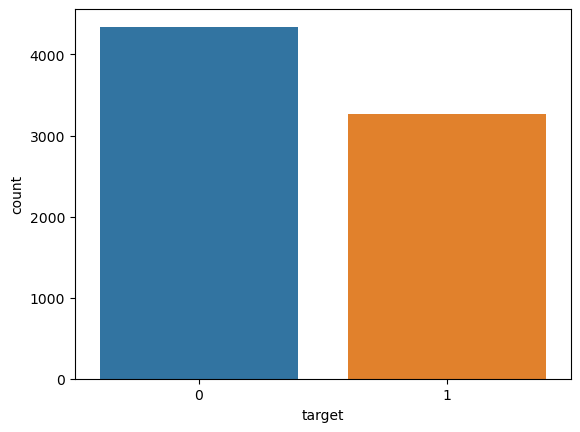

In [9]:
sns.countplot(data=train,x=train.target)

In [10]:
test.head(20)

id keyword                        location  \
0    0     NaN                             NaN   
1    2     NaN                             NaN   
2    3     NaN                             NaN   
3    9     NaN                             NaN   
4   11     NaN                             NaN   
5   12     NaN                             NaN   
6   21     NaN                             NaN   
7   22     NaN                             NaN   
8   27     NaN                             NaN   
9   29     NaN                             NaN   
10  30     NaN                             NaN   
11  35     NaN                             NaN   
12  42     NaN                             NaN   
13  43     NaN                             NaN   
14  45     NaN                             NaN   
15  46  ablaze                          London   
16  47  ablaze  Niall's place | SAF 12 SQUAD |   
17  51  ablaze                         NIGERIA   
18  58  ablaze                  Live On Webcam   
19  60  ablaze        Los Angeles, Califnordia   

                                                 text  
0                  Just happened a terrible car crash  
1   Heard about #earthquake is different cities, s...  
2   there is a forest fire at spot pond, geese are...  
3            Apocalypse lighting. #Spokane #wildfires  
4       Typhoon Soudelor kills 28 in China and Taiwan  
5                  We're shaking...It's an earthquake  
6   They'd probably still show more life than Arse...  
7                                   Hey! How are you?  
8                                    What a nice hat?  
9                                           Fuck off!  
10                              No I don't like cold!  
11                         NOOOOOOOOO! Don't do that!  
12                             No don't tell me that!  
13                                          What if?!  
14                                           Awesome!  
15  Birmingham Wholesale Market is ablaze BBC News...  
16  @sunkxssedharry will you wear shorts for race ...  
17  #PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...  
18  Check these out: http://t.co/rOI2NSmEJJ http:/...  
19  PSA: IÛªm splitting my personalities.\n\n?? t...

In [11]:
def cleaner(text):

  # take off html tags
  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic & numeric characters only
  text = re.sub("[^a-zA-Z0-9]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

# EDA

From initial data exploration it seems like keyword and location have null values in places, but it's mostly not useful information. We set up a cleaner to remove non-alphanumeric characters and to make the text all lowecase as well. Based on the initial information, all we have to do is put the information into a model through a tokenizer. 

In [12]:
train['cleaned_text'] = train['text'].apply(cleaner)

C:\Users\joeyc\AppData\Local\Temp\ipykernel_7620\2119329699.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


In [13]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                       cleaned_text  
0       1  our deeds are the reason of this earthquake ma...  
1       1              forest fire near la ronge sask canada  
2       1  all residents asked to shelter in place are be...  
3       1  13 000 people receive wildfires evacuation ord...  
4       1  just got sent this photo from ruby alaska as s...

In [14]:
X = train["text"]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=37)

X_test = test["text"]

In [15]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

In [16]:
thresh = 3

cnt=0
for key,value in tokenizer.word_counts.items():
  if value>=thresh:
    cnt=cnt+1

print(cnt)

3988


In [17]:
len(tokenizer.word_index)

19482

In [18]:
# prepare the tokenizer again
tokenizer = Tokenizer(num_words=cnt,oov_token='unk')

#prepare vocabulary
tokenizer.fit_on_texts(X_train)

In [19]:
# maximum sequence length allowed
max_len = 25

#convert text sequences into integer sequences
x_tr_seq = tokenizer.texts_to_sequences(X_train) 
x_val_seq = tokenizer.texts_to_sequences(X_val)

#padding up with zero 
x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len)
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len)

In [20]:
print(tokenizer.num_words)

3988


In [21]:
tokwords = tokenizer.num_words

# Model + Optimizer & Hyperparameter tuning

Now that we've made the tokenizer we can work on the model. I played around with different activation functions, and also different layers, but the general idea is to create the embedding layer that takes in the training information from the tokenizer, then create the rnn layer, then create hidden layers to feed information back into the rnn layer to hopefully create a better model.

Initially the model had 1 hidden layer and more were added until it became less useful at 4 layers.

The initial runs on this model had severe overfitting issues so dropout was added, added weight_decay to the optimizer and also changed the beta_1 values and learning rate to account for this.

In [95]:
#sequential model
model = Sequential()

#embedding layer
model.add(Embedding(tokwords, 50, input_shape=(max_len,), mask_zero=True))

#rnn layer
model.add(SimpleRNN(600,activation='relu', dropout=0.1))

#dense layer
model.add(Dense(80,activation='leaky_relu')) 
model.add(Dropout(0.4))
model.add(Dense(110,activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(140,activation='leaky_relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(1,activation='sigmoid'))

In [96]:
opt = keras.optimizers.Adam(learning_rate=0.00002, beta_1 = 0.8, weight_decay = 0.1)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [97]:
history =model.fit(x_tr_seq, y_train, batch_size=200, epochs=15, verbose=1, validation_data=(x_val_seq, y_val))

Epoch 1/15
31/31 [==============================] - 3s 48ms/step - loss: 0.6923 - accuracy: 0.5442 - val_loss: 0.6914 - val_accuracy: 0.5758
Epoch 2/15
31/31 [==============================] - 1s 43ms/step - loss: 0.6909 - accuracy: 0.5685 - val_loss: 0.6895 - val_accuracy: 0.5758
Epoch 3/15
31/31 [==============================] - 1s 42ms/step - loss: 0.6890 - accuracy: 0.5709 - val_loss: 0.6866 - val_accuracy: 0.5758
Epoch 4/15
31/31 [==============================] - 1s 39ms/step - loss: 0.6853 - accuracy: 0.5703 - val_loss: 0.6813 - val_accuracy: 0.5758
Epoch 5/15
31/31 [==============================] - 1s 42ms/step - loss: 0.6807 - accuracy: 0.5688 - val_loss: 0.6763 - val_accuracy: 0.5758
Epoch 6/15
31/31 [==============================] - 1s 41ms/step - loss: 0.6756 - accuracy: 0.5703 - val_loss: 0.6691 - val_accuracy: 0.5758
Epoch 7/15
31/31 [==============================] - 1s 41ms/step - loss: 0.6689 - accuracy: 0.5767 - val_loss: 0.6602 - val_accuracy: 0.5765
Epoch 8/15
31

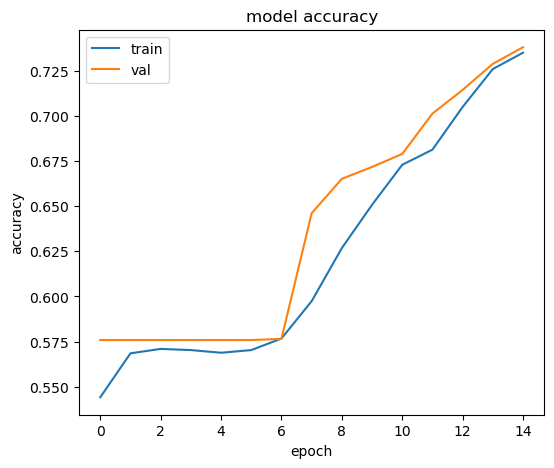

In [98]:
plt.figure(figsize=(6,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim(0.8, 1)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
pred_prob = model.predict(x_val_seq)

48/48 [==============================] - 1s 4ms/step


In [100]:
test['cleaned_text'] = test['text'].apply(cleaner)

C:\Users\joeyc\AppData\Local\Temp\ipykernel_7620\2119329699.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


In [101]:
Xtest=test['cleaned_text']
x_test_seq = tokenizer.texts_to_sequences(Xtest) 
x_test_seq = pad_sequences(x_test_seq, padding='post', maxlen=max_len)

In [102]:
y_test=model.predict(x_test_seq)

102/102 [==============================] - 1s 5ms/step


In [103]:
def classify(pred_prob,thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [104]:
threshold  = np.arange(0,0.5,0.01)
threshold

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

In [105]:
from sklearn import metrics
score=[]

#convert to 1 array
y_true = np.array(y_val).ravel() 

for thresh in threshold:
    
    #classes for each threshold
    y_pred_seq = classify(pred_prob,thresh) 

    #convert to 1d array
    y_pred = np.array(y_pred_seq).ravel()

    score.append(metrics.f1_score(y_true,y_pred))

In [106]:
opt = threshold[score.index(max(score))]
opt

0.34

In [107]:
classes = classify(y_test,opt)

In [108]:
classes = np.array(classes)
classes=classes.flatten()

In [109]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = classes

In [110]:
submission.head(20)

id  target
0    0       1
1    2       0
2    3       1
3    9       1
4   11       1
5   12       0
6   21       0
7   22       1
8   27       1
9   29       1
10  30       1
11  35       1
12  42       1
13  43       1
14  45       1
15  46       1
16  47       0
17  51       1
18  58       1
19  60       0

In [111]:
submission.to_csv('W4_Project.csv', index=False)

# Conclusion

Overall, the model ended up decent. It does not appear to suffer from overfitting, but it's also not incredibly accurate at roughly ~0.75 on both the training and validation sets. I learned that tuning the number of hidden layers is a pretty essential hyperparameter in NLP models, or at least this one. I also ran into pretty severe issues with some packages I was initially trying to use and had to pretty much do this project twice. I think if I had not run into those issues I would've liked to spend more time tuning the hyperparameters and using different activation functions/dropout rates to see if I could make a better model that did not overfit. 